In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import os

In [2]:
#load data
os.chdir('../..')
df=pd.read_csv('./data/csv/graph-features-reduced.csv')
#drop node and cluster columns
df.drop(['node','cluster'],axis=1,inplace=True)
#rename label values botnet to 1 and normal to zero
df['label'].replace({'botnet':1,'normal':0},inplace=True)

In [3]:
#train logistic regression model with all numerical features
classif = setup(data = df, target = 'label', session_id=123, train_size=0.8,numeric_features=['ID','OD','IDW','ODW','LCC','AC','BC'],silent=True,remove_perfect_collinearity=False,data_split_stratify=True)

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(18693, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [4]:
#add balanced accuracy metric
add_metric('balanced_accuracy', 'Balanced Accuracy', balanced_accuracy_score, greater_is_better=True)

#Add specificity metric
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() #ravel flattens the array
    specificity = tn / (tn+fp)
    return specificity
    
add_metric('specificity', 'Specificity', specificity_score, greater_is_better=True)
print('')


In [8]:
max_features=[1,2,3,4,5,6]
max_depth=[1,2,3]
n_estimators=[10,50,100,500,1000]
totit=len(max_features)*len(max_depth)*len(n_estimators)
itnum=0
#create dataframe for storing results
results=pd.DataFrame(columns=['max_features','max_depth','n_estimators','recall_mean','recall_stdev','specificity_mean','specificity_std','balanced_acc_mean','balanced_acc_std'])
for feat in max_features:
    for depth in max_depth:
        for est in n_estimators:
            print('Iteration number: ',itnum,'/',totit)
            rf=create_model('rf',max_features=feat,max_depth=depth,n_estimators=est,class_weight='balanced')# if unbalanced works bad
            #To train on unbalanced data use class_weight='balanced'
            rf_results=pull()
            rf_recall_mean=rf_results.loc['Mean','Recall']
            rf_recall_stdev=rf_results.loc['Std','Recall']
            rf_specificity_mean=rf_results.loc['Mean','Specificity']
            rf_specificity_stdev=rf_results.loc['Std','Specificity']
            rf_balanced_acc_mean=rf_results.loc['Mean','Balanced Accuracy']
            rf_balanced_acc_stdev=rf_results.loc['Std','Balanced Accuracy']           

            #store results
            results=results.append({'max_features':feat,'max_depth':depth,'n_estimators':est,'recall_mean':rf_recall_mean,'recall_stdev':rf_recall_stdev,'specificity_mean':rf_specificity_mean,'specificity_std':rf_specificity_stdev,'balanced_acc_mean':rf_balanced_acc_mean,'balanced_acc_std':rf_balanced_acc_stdev},ignore_index=True)
            itnum+=1
            


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
Fold,,,,,,,,,
0,0.9592,0.9923,1.0000,0.0317,0.0615,0.0591,0.1745,0.9796,0.9592
1,0.9719,0.9789,0.5000,0.0238,0.0455,0.0430,0.1045,0.7363,0.9726
2,0.9425,0.9933,1.0000,0.0227,0.0444,0.0419,0.1464,0.9712,0.9424
3,0.9425,0.9956,1.0000,0.0227,0.0444,0.0419,0.1464,0.9712,0.9424
4,0.9425,0.9113,0.5000,0.0116,0.0227,0.0202,0.0696,0.7215,0.9431
5,0.9425,1.0000,1.0000,0.0227,0.0444,0.0419,0.1463,0.9712,0.9424
6,0.9666,0.9307,0.5000,0.0200,0.0385,0.0360,0.0950,0.7336,0.9672
7,0.9505,1.0000,1.0000,0.0263,0.0513,0.0488,0.1582,0.9752,0.9504
8,0.9726,0.9200,0.0000,0.0000,0.0000,-0.0026,-0.0060,0.4869,0.9739


Iteration number:  90 / 90


In [9]:
results

,max_features,max_depth,n_estimators,recall_mean,recall_stdev,specificity_mean,specificity_std,balanced_acc_mean,balanced_acc_std
0,1.0,1.0,10.0,0.95,0.1500,0.8559,0.0176,0.9030,0.0755
1,1.0,1.0,50.0,0.95,0.1500,0.8389,0.0100,0.8944,0.0726
2,1.0,1.0,100.0,0.95,0.1500,0.8252,0.0079,0.8876,0.0735
3,1.0,1.0,500.0,0.95,0.1500,0.8279,0.0085,0.8890,0.0732
4,1.0,1.0,1000.0,0.95,0.1500,0.8300,0.0100,0.8900,0.0736
...,...,...,...,...,...,...,...,...,...
85,6.0,3.0,10.0,0.70,0.3317,0.9519,0.0201,0.8260,0.1606
86,6.0,3.0,50.0,0.75,0.3354,0.9388,0.0248,0.8444,0.1603
87,6.0,3.0,100.0,0.70,0.3317,0.9404,0.0258,0.8202,0.1555
88,6.0,3.0,500.0,0.70,0.3317,0.9564,0.0108,0.8282,0.1614


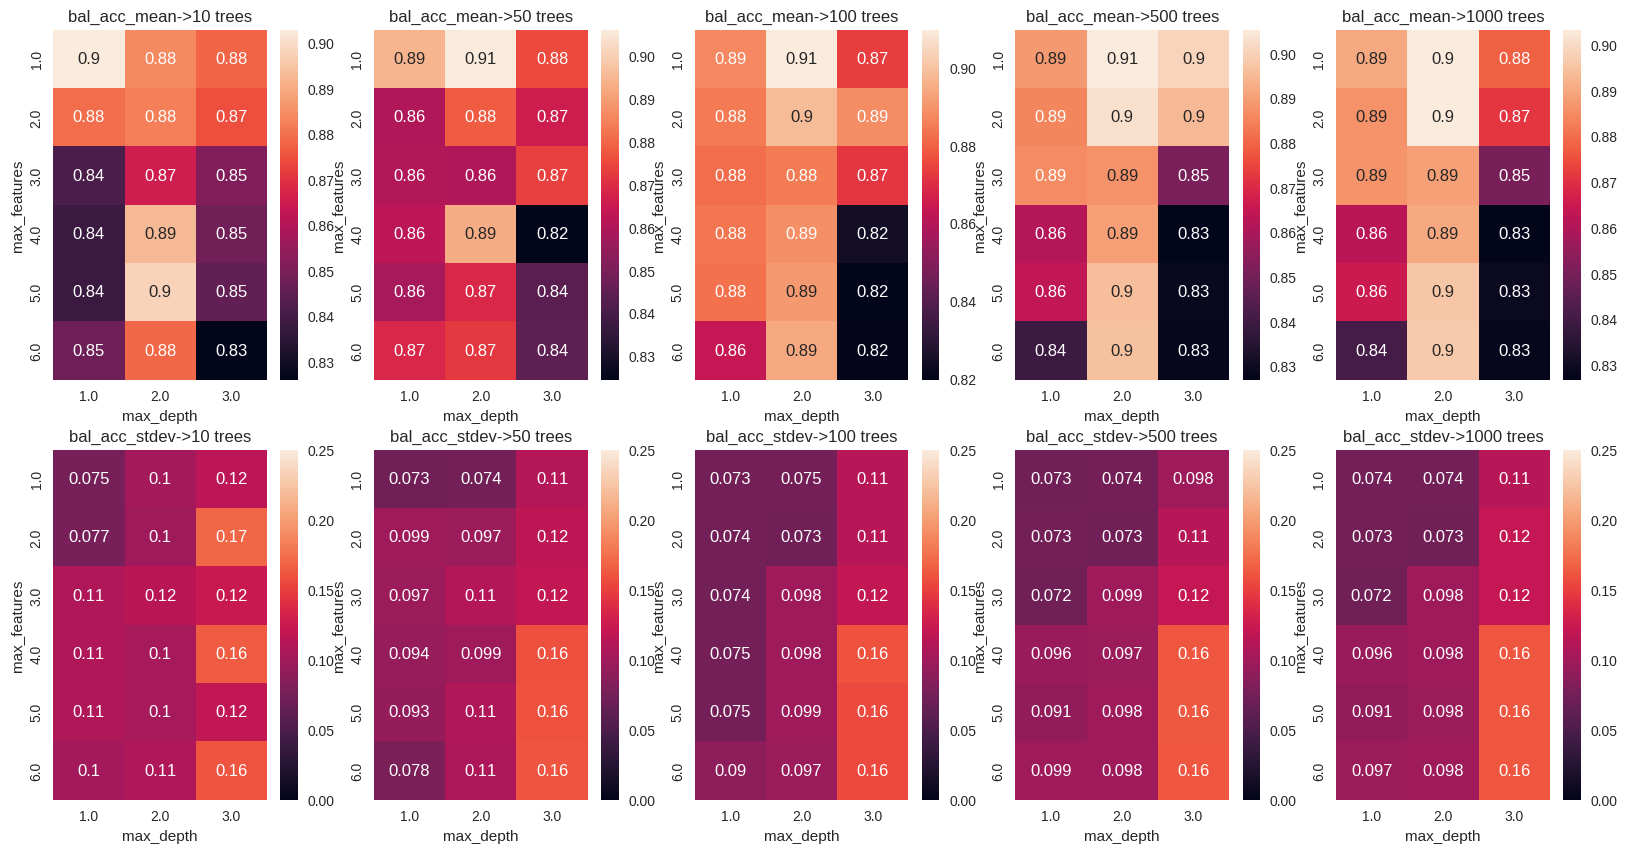

In [10]:
#A good way to visualize a 2 dimensional grid is to use a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

#Creat a 2x5 plot of heatmaps with balanced accuracy mean and stdev for each of the 5 n_estimator values
fig, axs = plt.subplots(2,5,figsize=(20,10))
for i in range(0,5): 
    sns.heatmap(results[results['n_estimators']==n_estimators[i]].pivot(index='max_features',columns='max_depth',values='balanced_acc_mean'),ax=axs[0,i],annot=True)
    axs[0,i].set_title('bal_acc_mean->'+str(n_estimators[i])+' trees')
    sns.heatmap(results[results['n_estimators']==n_estimators[i]].pivot(index='max_features',columns='max_depth',values='balanced_acc_std'),ax=axs[1,i],annot=True,vmin=0,vmax=0.25)
    axs[1,i].set_title('bal_acc_stdev->'+str(n_estimators[i])+' trees')
plt.show()

In [21]:
#Now we pick the best model and test it
rf2=create_model('rf',max_features=1,max_depth=2,n_estimators=100,class_weight='balanced')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
Fold,,,,,,,,,
0,0.8697,0.9980,1.0000,0.0102,0.0201,0.0175,0.0940,0.9347,0.8695
1,0.8783,0.9451,1.0000,0.0109,0.0215,0.0189,0.0977,0.9391,0.8782
2,0.8603,0.9963,1.0000,0.0095,0.0188,0.0162,0.0903,0.9301,0.8601
3,0.8703,0.9923,1.0000,0.0102,0.0202,0.0176,0.0942,0.9351,0.8701
4,0.8803,0.9159,1.0000,0.0110,0.0219,0.0193,0.0986,0.9401,0.8801
5,0.8809,0.9963,1.0000,0.0111,0.0220,0.0194,0.0989,0.9404,0.8808
6,0.8709,0.8845,0.5000,0.0052,0.0103,0.0076,0.0405,0.6857,0.8714
7,0.8696,0.9956,1.0000,0.0102,0.0201,0.0175,0.0939,0.9347,0.8694
8,0.8709,0.9762,1.0000,0.0103,0.0203,0.0177,0.0945,0.9354,0.8707


In [13]:
#Get balanced accuracy, recall and specificity for test set
 #get pycaret test set
test_df=get_config('X_test')
test_df['prediction']=predict_model(rf2,data=test_df)['Label']
test_df['label']=get_config('y_test')

#Get balanced accuracy, recall and specificity for test set
tn, fp, fn, tp = confusion_matrix(test_df['label'], test_df['prediction']).ravel()

recall=tp/(tp+fn)
specificity=tn/(tn+fp)
balanced_acc=(recall+specificity)/2
print('Balanced Accuracy:',balanced_acc)
print('Recall:',recall)
print('Specificity:',specificity)

Balanced Accuracy: 0.9301017675415104
Recall: 1.0
Specificity: 0.8602035350830209


In [15]:
#results.to_csv('./data/csv/rf_results.csv',index=False)